In [1]:
import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)


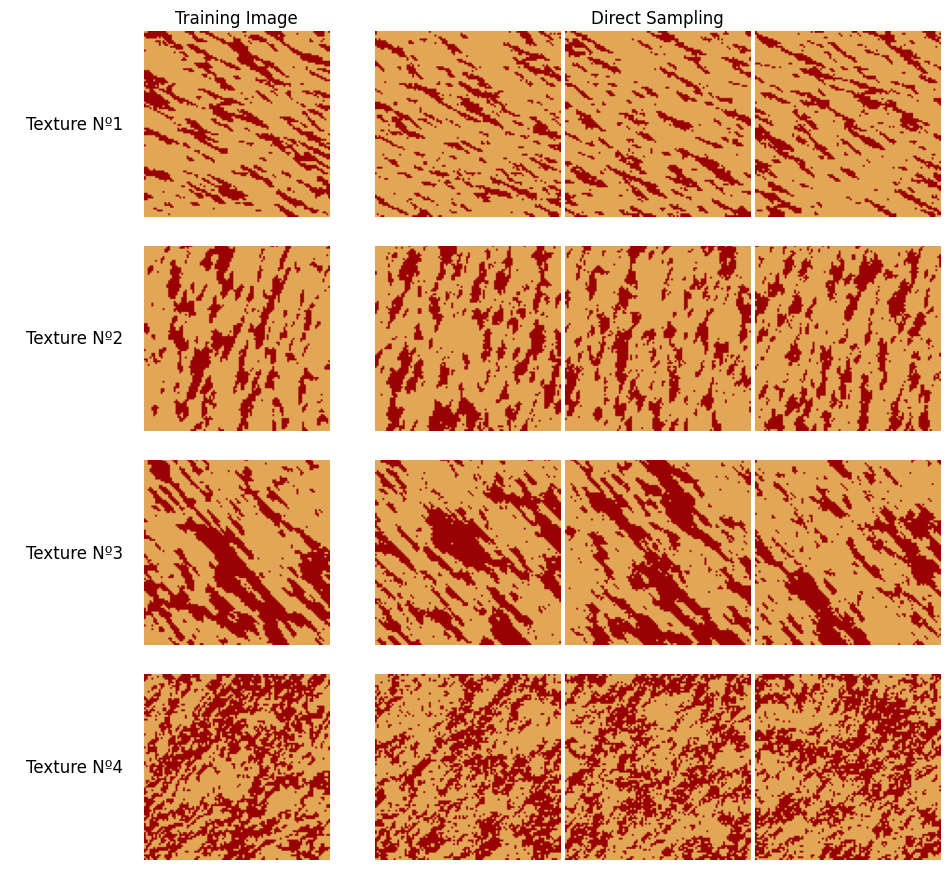

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tex_cmap = mcolors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, '#e2a858'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

path = Path('/Users/arstanbek/Projects/BiTis/data')

pattern_ids = [25, 2, 34, 5]

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(12, 11),
                        width_ratios=[0.7, 1, 0.2, 1, 1, 1],
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
for ax in axs.flatten():
    ax.axis('off')

for i, pattern_id in enumerate(pattern_ids):
    tr_filename = f'or_tex_{pattern_id}.png'
    tr_image = ImageParser.read_png(path.joinpath('training', tr_filename))
    tr_image = tr_image[:100, :100]
    tr_image[tr_image == 0] = 1

    axs[i, 1].imshow(tr_image.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower',
                     aspect='equal')

    img = []
    dens = []
    inds = np.random.choice(np.arange(100), 3, replace=False)

    for idx in inds:
        image = ImageParser.read_png(path.joinpath(f'simulated_{pattern_id}',
                                                   f'gen_tex_{pattern_id}_{idx}.png'))
        img.append(image[:100, :100])
        dens.append(np.mean(image == 2))

    for ax_id, im in zip([3, 4, 5], img):
        ax = axs[i, ax_id]
        ax.imshow(im.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower')

axs[0, 1].set_title('Training Image', fontsize=12)
axs[0, 4].set_title('Direct Sampling', fontsize=12)

for i, text in enumerate(['Texture Nº1', 'Texture Nº2',
                          'Texture Nº3', 'Texture Nº4']):
    axs[i, 0].text(0.5, 0.5, text, fontsize=12, ha='center', va='center',
                   transform=axs[i, 0].transAxes, rotation=0)

plt.show()

In [114]:
fig.savefig('ds_generation_images.png', dpi=300, bbox_inches='tight')

In [3]:
import pandas as pd
from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def calc_props(image):
    pattern_builder = PatternPropertiesBuilder(area_quantile=0.95,
                                               area_min=10)
    pattern_props = pattern_builder.build(image == 2)
    return pattern_props, pattern_builder.object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            pattern_props, object_props = calc_props(image)
            pattern_props['pattern_id'] = pattern_id

            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_pattern_props.append(pattern_props)
            all_object_props.append(object_props)
    
    all_pattern_props = pd.concat(all_pattern_props).reset_index(drop=True)
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_pattern_props, all_object_props



data, objects_data = make_pattern_stats(path, [25, 2, 34, 5])

In [9]:
data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

data['deg_orientation'] = np.degrees(data['orientation'])

data.groupby('pattern_id').describe().T

pattern_id                           2           5           25          34
density               count  100.000000  100.000000  100.000000  100.000000
                      mean     0.258667    0.418056    0.206165    0.383636
                      std      0.021066    0.029331    0.018304    0.050740
                      min      0.199800    0.334400    0.157400    0.269800
                      25%      0.243350    0.399475    0.194875    0.347850
                      50%      0.259300    0.420350    0.203850    0.381900
                      75%      0.276025    0.437675    0.217125    0.423600
                      max      0.300300    0.507800    0.259200    0.489200
elongation            count  100.000000  100.000000  100.000000  100.000000
                      mean     2.641107    2.006752    3.949987    3.067594
                      std      0.296243    0.188804    0.352819    0.414315
                      min      2.145134    1.573246    3.185687    2.153236
                      25%      2.448839    1.867941    3.682025    2.796243
                      50%      2.607216    2.004942    3.958161    3.075552
                      75%      2.836802    2.112864    4.160073    3.316002
                      max      3.508849    2.525920    4.724516    4.345089
orientation           count  100.000000  100.000000  100.000000  100.000000
                      mean     1.379635    0.746809   -0.471961   -0.834826
                      std      0.055950    0.188357    0.042396    0.065848
                      min      1.246001    0.329705   -0.577988   -1.116956
                      25%      1.345621    0.650027   -0.502744   -0.868449
                      50%      1.378719    0.748643   -0.472208   -0.828132
                      75%      1.413424    0.858885   -0.441227   -0.795543
                      max      1.503077    1.326410   -0.373897   -0.686923
compactness           count  100.000000  100.000000  100.000000  100.000000
                      mean     0.134499    0.345428    0.098531    0.323630
                      std      0.021268    0.039473    0.016058    0.057726
                      min      0.083500    0.238400    0.063800    0.200400
                      25%      0.120550    0.324425    0.085725    0.275475
                      50%      0.132250    0.343000    0.095100    0.328400
                      75%      0.148925    0.370875    0.111175    0.363775
                      max      0.190700    0.473100    0.135900    0.442400
structural_anisotropy count  100.000000  100.000000  100.000000  100.000000
                      mean     5.593247    2.411377    9.299338    8.221242
                      std      1.422877    0.868336    2.145321    3.516029
                      min      3.207595    1.398742    5.880090    2.740531
                      25%      4.712956    1.919669    7.740251    6.091686
                      50%      5.314954    2.181597    9.114660    7.437338
                      75%      6.262907    2.558771   10.538592    9.318753
                      max     11.356534    6.536841   15.124142   18.926340
complexity            count  100.000000  100.000000  100.000000  100.000000
                      mean    73.498513  135.579315   72.333976   60.755969
                      std      5.309101    9.233061    7.032958    6.415314
                      min     60.048487  111.634113   52.368011   44.842738
                      25%     70.010325  128.394758   68.085232   56.321204
                      50%     73.520378  136.427249   72.396737   60.780771
                      75%     76.533399  141.983412   76.877566   64.494523
                      max     89.441709  154.504640   86.234970   75.774982
deg_orientation       count  100.000000  100.000000  100.000000  100.000000
                      mean    79.047286   42.788983  -27.041374  -47.831979
                      std      3.205722   10.792080    2.429105    3.772837
                      min     71.390600   18.890

In [6]:
# path = Path('/Users/arstanbek/Projects/BiTis/data/training')

tr_props = []
tr_objects = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training', 
                                        f'or_tex_{pattern_id}.png'))
    pprops, oprops = calc_props(tr_image)
    pprops['pattern_id'] = pattern_id

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    tr_props.append(pprops)
    tr_objects.append(oprops)

tr_data = pd.concat(tr_props).reset_index(drop=True)
tr_objects = pd.concat(tr_objects).reset_index(drop=True)
tr_data.loc[tr_data['orientation'] > 0.5 * np.pi, 'orientation'] -= np.pi

In [10]:
tr_data['deg_orientation'] = np.degrees(tr_data['orientation'])
tr_data.groupby('pattern_id').describe().T

pattern_id                          2           5          25         34
density               count   1.000000    1.000000   1.000000   1.000000
                      mean    0.235700    0.452000   0.251000   0.360300
                      std          NaN         NaN        NaN        NaN
                      min     0.235700    0.452000   0.251000   0.360300
                      25%     0.235700    0.452000   0.251000   0.360300
                      50%     0.235700    0.452000   0.251000   0.360300
                      75%     0.235700    0.452000   0.251000   0.360300
                      max     0.235700    0.452000   0.251000   0.360300
elongation            count   1.000000    1.000000   1.000000   1.000000
                      mean    2.629175    1.793300   4.342572   3.909836
                      std          NaN         NaN        NaN        NaN
                      min     2.629175    1.793300   4.342572   3.909836
                      25%     2.629175    1.793300   4.342572   3.909836
                      50%     2.629175    1.793300   4.342572   3.909836
                      75%     2.629175    1.793300   4.342572   3.909836
                      max     2.629175    1.793300   4.342572   3.909836
orientation           count   1.000000    1.000000   1.000000   1.000000
                      mean    1.331358    0.872939  -0.486476  -0.854912
                      std          NaN         NaN        NaN        NaN
                      min     1.331358    0.872939  -0.486476  -0.854912
                      25%     1.331358    0.872939  -0.486476  -0.854912
                      50%     1.331358    0.872939  -0.486476  -0.854912
                      75%     1.331358    0.872939  -0.486476  -0.854912
                      max     1.331358    0.872939  -0.486476  -0.854912
compactness           count   1.000000    1.000000   1.000000   1.000000
                      mean    0.113800    0.391400   0.126600   0.305100
                      std          NaN         NaN        NaN        NaN
                      min     0.113800    0.391400   0.126600   0.305100
                      25%     0.113800    0.391400   0.126600   0.305100
                      50%     0.113800    0.391400   0.126600   0.305100
                      75%     0.113800    0.391400   0.126600   0.305100
                      max     0.113800    0.391400   0.126600   0.305100
structural_anisotropy count   1.000000    1.000000   1.000000   1.000000
                      mean    4.413714    3.443814  11.004543  10.879331
                      std          NaN         NaN        NaN        NaN
                      min     4.413714    3.443814  11.004543  10.879331
                      25%     4.413714    3.443814  11.004543  10.879331
                      50%     4.413714    3.443814  11.004543  10.879331
                      75%     4.413714    3.443814  11.004543  10.879331
                      max     4.413714    3.443814  11.004543  10.879331
complexity            count   1.000000    1.000000   1.000000   1.000000
                      mean   66.161508  147.415642  86.257675  61.680524
                      std          NaN         NaN        NaN        NaN
                      min    66.161508  147.415642  86.257675  61.680524
                      25%    66.161508  147.415642  86.257675  61.680524
                      50%    66.161508  147.415642  86.257675  61.680524
                      75%    66.161508  147.415642  86.257675  61.680524
                      max    66.161508  147.415642  86.257675  61.680524
deg_orientation       count   1.000000    1.000000   1.000000   1.000000
                      mean   76.281196   50.015721 -27.873024 -48.982871
                      std          NaN         NaN        NaN        NaN
                      min    76.281196   50.015721 -27.873024 -48.982871
                      25%    76.281196   50.015721 -27.873024 -48.982871
                      50%    76.281196   50.015721 -27.873

In [76]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Fibrotic Tissue')
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0, title=''):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=12)
    # ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)
    ax.set_title(title, fontsize=14, loc='left')


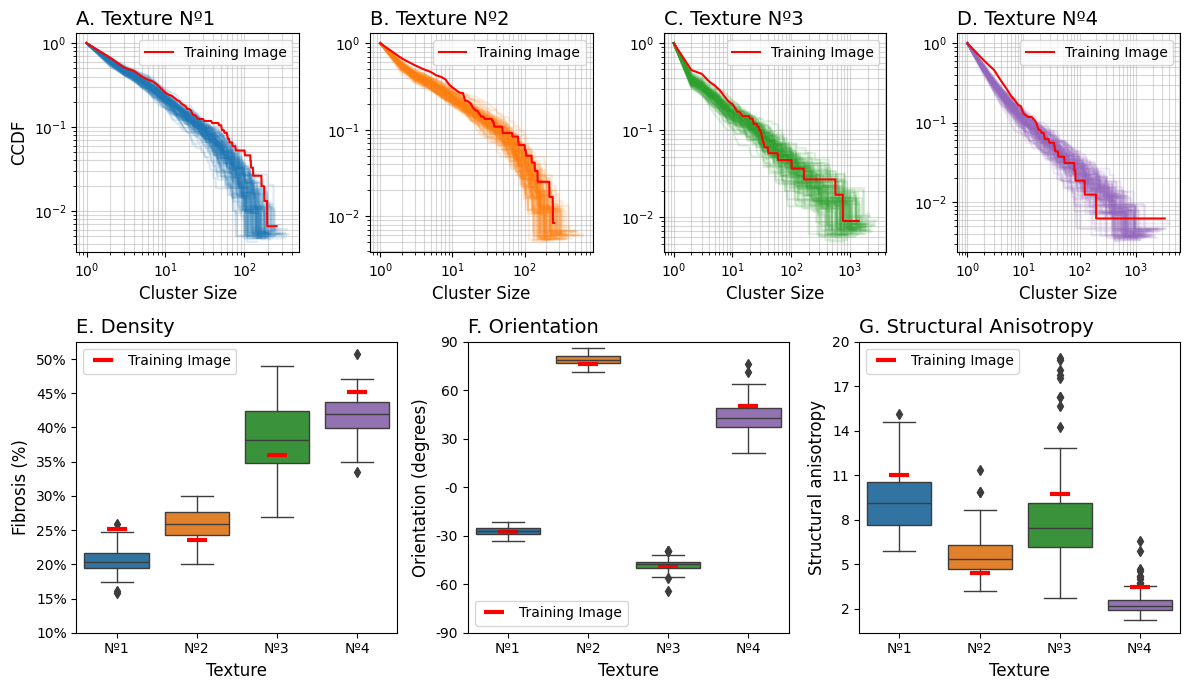

In [79]:
import seaborn as sns
import matplotlib as mpl


data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
axs_ids = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
titles = ['A. Texture Nº1', 'B. Texture Nº2', 'C. Texture Nº3', 'D. Texture Nº4',
          'E. Density', 'F. Orientation', 'G. Structural Anisotropy']

fig, axs = plt.subplot_mosaic([['a', 'a', 'a',
                                'b', 'b', 'b',
                                'c', 'c', 'c',
                                'd', 'd', 'd'],
                               ['e', 'e', 'e', 'e',
                                'f', 'f', 'f', 'f',
                                'g', 'g', 'g', 'g'],
                               ], 
                                figsize=(12, 7),
                                height_ratios=[3, 4])

for i, prop in enumerate(['density', 'orientation', 'structural_anisotropy']):
    sns.boxplot(x='pattern_id', y=prop, data=data, order=pattern_ids, ax=axs[axs_ids[i+4]],
                palette=colors, linewidth=1)
    axs[axs_ids[i+4]].plot(tr_data[prop], marker='_', markersize=15, markeredgewidth=3,
                ls='', color='r', label='Training Image')
    axs[axs_ids[i+4]].set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=10)
    axs[axs_ids[i+4]].set_xlabel('Texture', fontsize=12)
    axs[axs_ids[i+4]].set_title(titles[i + 4], fontsize=14, loc='left')

axs['e'].legend(loc='upper left', fontsize=10)
axs['e'].set_yticks(np.arange(0.1, 0.55, 0.05))
axs['e'].set_yticklabels(axs['e'].get_yticks(), fontsize=10)
axs['e'].set_ylabel('Fibrosis (%)', fontsize=12)
axs['e'].yaxis.set_major_formatter(
    mpl.ticker.PercentFormatter(xmax=1, decimals=0))

axs['f'].legend(loc='lower left', fontsize=10)
axs['f'].set_ylim(-np.pi/2, np.pi/2)
axs['f'].set_yticks(np.arange(-np.pi/2, 1.1 * np.pi/2, np.pi/6))
axs['f'].set_yticklabels(axs['f'].get_yticks(), fontsize=10)
axs['f'].set_ylabel('Orientation (degrees)', fontsize=12)
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{np.rad2deg(x):.0f}'))

axs['g'].legend(loc='upper left', fontsize=10)
axs['g'].set_yticks(np.arange(2, 21, 3))
axs['g'].set_yticklabels(axs['g'].get_yticks(), fontsize=10)
axs['g'].set_ylabel('Structural anisotropy', fontsize=12)
axs['g'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))

for i, pattern_id in enumerate(pattern_ids):
    for j in range(100):
        draw_ccdf(axs[axs_ids[i]], objects_data[(objects_data['pattern_id'] == pattern_id) &
                                            (objects_data['sample_id'] == j)],
                                            color=colors[i], alpha=0.15)
    draw_ccdf(axs[axs_ids[i]], tr_objects[tr_objects['pattern_id'] == pattern_id],
              label='Training Image', color='red', alpha=1.0, title=titles[i])
    axs[axs_ids[i]].legend(loc='upper right', fontsize=10)
axs['a'].set_ylabel('CCDF', fontsize=12)

plt.tight_layout()
plt.show()

In [80]:
fig.savefig('ds_generation_quality.png', dpi=300, bbox_inches='tight')

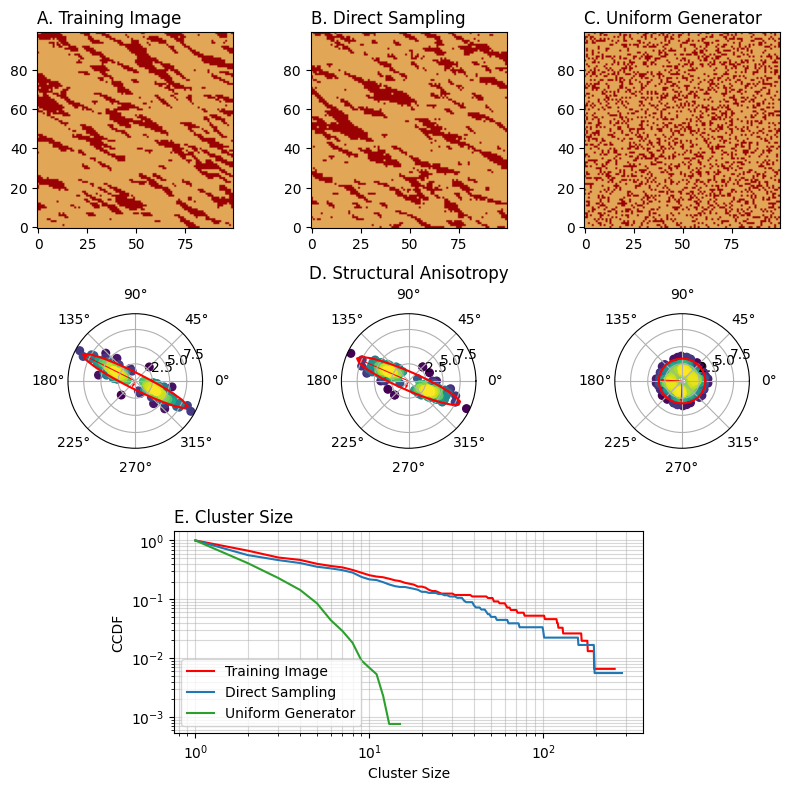

In [160]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.covariance import EmpiricalCovariance
from skimage import measure, morphology, segmentation

from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, objects_props, n_std=2):
    objects_props = objects_props[objects_props['area'] >= 5]
    r = objects_props['axis_ratio'].values
    theta = objects_props['orientation'].values

    r = np.concatenate([r, r])
    theta = np.concatenate([theta, theta + np.pi])

    theta = swap_axis(theta)

    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    full_theta = dist_ellipse.full_theta
    orientation = dist_ellipse.orientation
    r, theta, d = PolarPlots.sort_by_density(r, theta)

    ax.scatter(theta, r, c=d, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')


def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label=''):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('Fibrotic Tissue')
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='tab:blue'):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color)
    ax.set_xlabel('Cluster Size', fontsize=10)
    ax.set_ylabel('CCDF', fontsize=10)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)


def draw_perimeter_cdf(ax, objects_props, label=''):
    count = np.bincount(objects_props['area'].values,
                        weights=objects_props['perimeter'].values)
    area_bins = np.arange(1 + objects_props['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]

    cdf = np.cumsum(count)
    
    ax.plot(area_bins, cdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('Perimeter')
    ax.set_xscale('log')
    ax.set_yscale('log')


pattern_id = pattern_ids[0]
sample_id = 7

im = plt.imread(path.joinpath('training', f'or_tex_{pattern_id}.png'))
nim = np.where(rgb2gray(im) > 0.5, 1, 2)
nim = nim[:100, :100].T

im = plt.imread(path.joinpath(f'simulated_{pattern_id}',
                              f'gen_tex_{pattern_id}_{sample_id}.png'))
nim_gen = np.where(rgb2gray(im) > 0.5, 1, 2)
nim_gen = nim_gen[:100, :100].T

nim_uni = np.random.random(nim_gen.shape) < (np.sum(nim == 2) / nim.size)

nim_uni = nim_uni.astype(int) + 1

textures = []
pattern_props = []

for im in [nim, nim_gen, nim_uni]:
    pattern_builder = PatternPropertiesBuilder(area_quantile=0.95)
    pattern_properties = pattern_builder.build(im == 2)
    pattern_props.append(pattern_properties)

    texture = Texture()
    texture.matrix = im
    texture.properties["pattern"] = pattern_properties
    texture.properties["object_props"] = pattern_builder.object_props
    textures.append(texture)

fig, axs = plt.subplot_mosaic([['a', 'a', 'b', 'b', 'c', 'c'],
                                ['d', 'd', 'e', 'e', 'f', 'f'],
                                ['empty_l', 'g', 'g', 'g', 'g', 'empty_r']],
                                per_subplot_kw={('d', 'e', 'f'): {'projection': 'polar'}},
                                height_ratios=[3, 2, 3],
                                figsize=(8, 8))

for k, ax in axs.items():
    if 'empty' in k:
        ax.axis('off')

axs['b'].sharex(axs['a'])
axs['b'].sharey(axs['a'])

axs['c'].sharex(axs['a'])
axs['c'].sharey(axs['a'])

axs['d'].sharex(axs['e'])
axs['d'].sharey(axs['e'])

axs['f'].sharex(axs['e'])
axs['f'].sharey(axs['e'])

draw_anisotropy(axs['d'], textures[0].properties["object_props"])
draw_anisotropy(axs['e'], textures[1].properties["object_props"])
draw_anisotropy(axs['f'], textures[2].properties["object_props"])


draw_ccdf(axs['g'],
            textures[0].properties["object_props"],
            label='Training Image', color='red')
draw_ccdf(axs['g'],
            textures[1].properties["object_props"],
            label='Direct Sampling', color='tab:blue')
draw_ccdf(axs['g'],
            textures[2].properties["object_props"],
            label='Uniform Generator', color='tab:green')


axs['g'].legend()

axs['a'].imshow(textures[0].matrix, origin='lower', vmin=0, vmax=2,
                cmap=tex_cmap)
axs['a'].set_title('A. Training Image', loc='left', fontsize=12)

axs['b'].imshow(textures[1].matrix, origin='lower', vmin=0, vmax=2,
                cmap=tex_cmap)
axs['b'].set_title("B. Direct Sampling", loc='left', fontsize=12)

axs['c'].imshow(textures[2].matrix, origin='lower', vmin=0, vmax=2,
                cmap=tex_cmap)
axs['c'].set_title("C. Uniform Generator", loc='left', fontsize=12)

axs['e'].set_title('D. Structural Anisotropy', loc='center', fontsize=12)
axs['g'].set_title('E. Cluster Size', loc='left', fontsize=12)

plt.tight_layout()
plt.show()


In [161]:
fig.savefig('ds_generation_quality_plots.png', dpi=300, bbox_inches='tight')